In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math

In [2]:
from google.colab import files
upload = files.upload()

Saving traffic.csv to traffic.csv


In [3]:
traffic_try = pd.read_csv("traffic.csv")
traffic_try.head(3)

,DateTime,Junction,Vehicles,ID
0,2015-11-1 0:00,1,15,20151101001
1,2015-11-1 1:00,1,13,20151101011
2,2015-11-1 2:00,1,10,20151101021


In [4]:
traffic_try.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [5]:
traffic_try["DateTime"]= pd.to_datetime(traffic_try["DateTime"])
data = traffic_try.drop(["ID"], axis=1) # dropping IDs
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


Text(0.5, 0, 'Date')

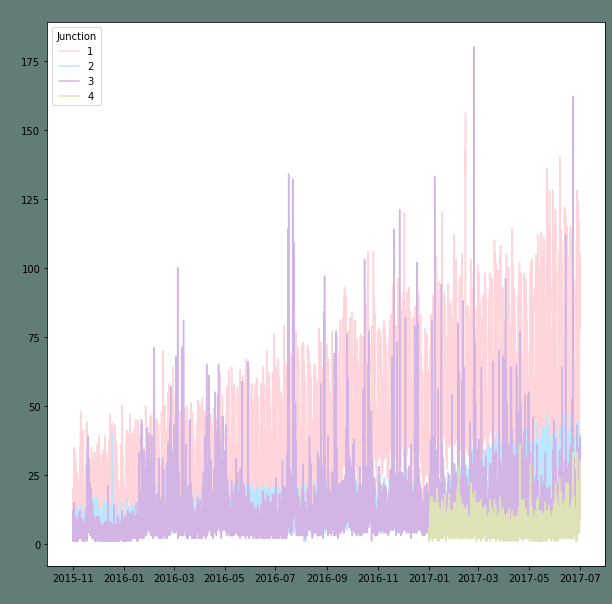

In [6]:
df=data.copy() 
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(10,10),facecolor="#627D78")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years", color="#627D78")
Time_series.set_ylabel("Number of Vehicles", color="#627D78")
Time_series.set_xlabel("Date", color="#627D78")

In [7]:
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


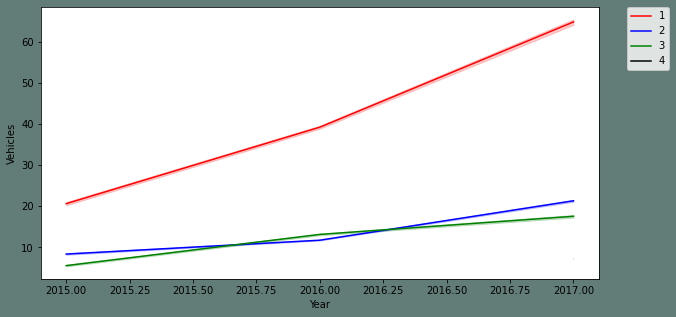

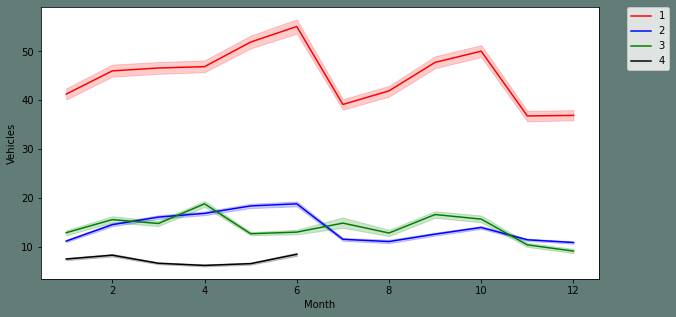

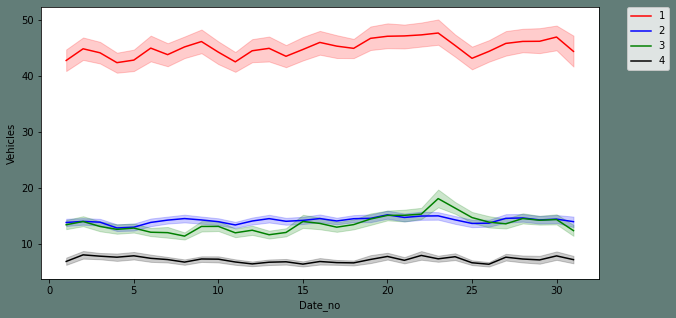

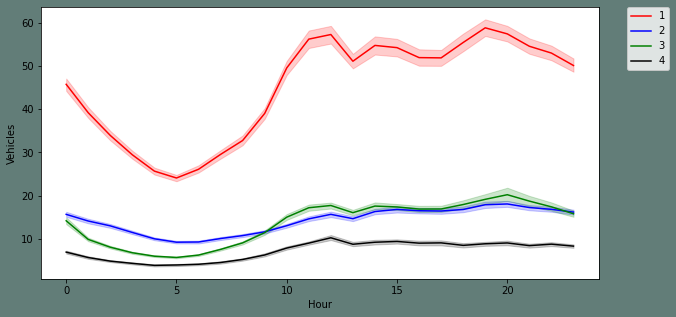

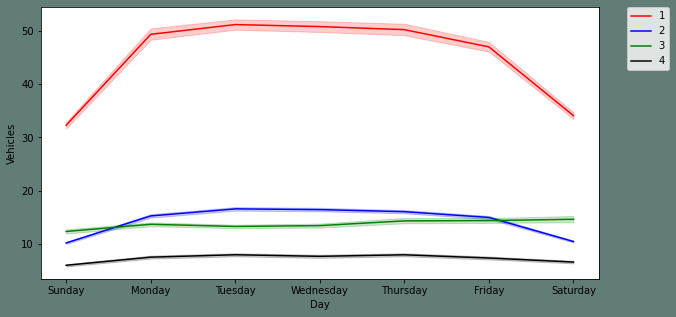

In [8]:
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10,5),facecolor="#627D78")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=['red','blue','green','black'])
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Text(0.5, 0, 'Date')

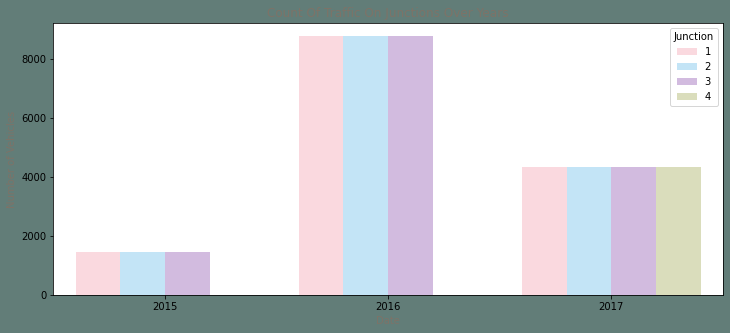

In [9]:
plt.figure(figsize=(12,5),facecolor="#627D78")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years", color="#7D7368")
count.set_ylabel("Number of Vehicles", color="#7D7368")
count.set_xlabel("Date", color="#7D7368")

In [10]:
df[(df['Year'] == 2017) & (df['Junction'] == 3)].count()

DateTime    4344
Junction    4344
Vehicles    4344
Year        4344
Month       4344
Date_no     4344
Hour        4344
Day         4344
dtype: int64

***Data transformation and Preprocessing***

In [11]:
#Pivoting data fron junction 
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe(percentiles=None, include=None, exclude=None)

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

In [12]:
df_J[[('Vehicles', 4)]].isnull().sum() # missing values in Junction 4

          Junction
Vehicles  4           10248
dtype: int64

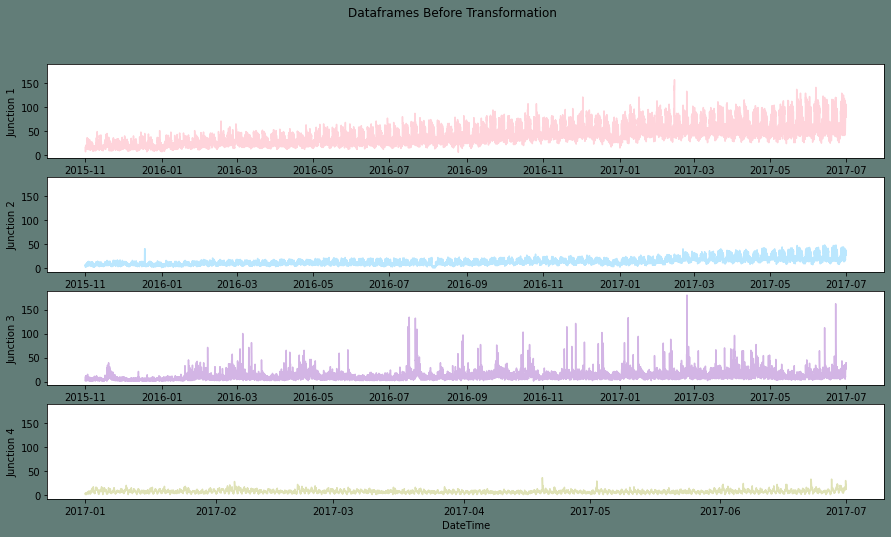

In [13]:
#Creating new sets
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
   i.columns= i.columns.droplevel(level=1)  

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")
    
    
#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

In [14]:
df_1.head()

,Vehicles
DateTime,
2015-11-01 00:00:00,15.0
2015-11-01 01:00:00,13.0
2015-11-01 02:00:00,10.0
2015-11-01 03:00:00,7.0
2015-11-01 04:00:00,9.0


In [40]:
# Standardizing Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    print("mean of normalized df: ", df_normalized.mean())
    print("std of normalized df: ", df_normalized.std())
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [41]:
df_1.columns

Index(['Vehicles'], dtype='object')

In [42]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

mean of normalized df:  Vehicles    1.246566e-16
dtype: float64
std of normalized df:  Vehicles    1.0
dtype: float64
mean of normalized df:  Vehicles    1.246566e-16
dtype: float64
std of normalized df:  Vehicles    1.0
dtype: float64


<ipython-input-42-db733117bb69>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_N1["Diff"]= Diff_1


mean of normalized df:  Vehicles    7.791039e-17
dtype: float64
std of normalized df:  Vehicles    1.0
dtype: float64
mean of normalized df:  Vehicles    1.308550e-17
dtype: float64
std of normalized df:  Vehicles    1.0
dtype: float64


<ipython-input-42-db733117bb69>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_N3["Diff"]= Diff_3
<ipython-input-42-db733117bb69>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_N4["Diff"]= Diff_4


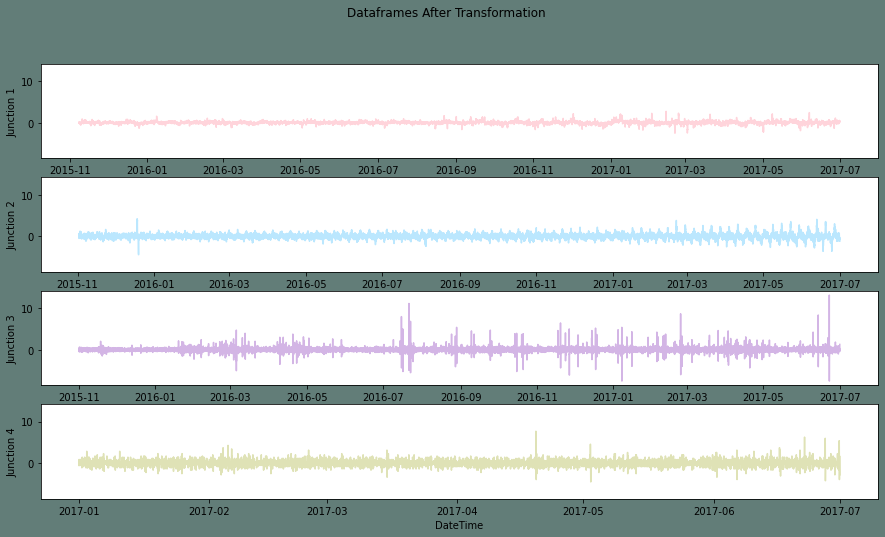

In [18]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")

In [19]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415504
p-value: 4.798539876395756e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.79589102694011
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832504
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.97909256305238
p-value: 2.7787875325952613e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [20]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

**Model Building**

In [25]:
#Model for the prediction
def LSTM_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!
 
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=SGD(decay=1e-7, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, epochs=50, batch_size=150,callbacks=[early_stopping])
    pred_LSTM= model.predict(X_Test)
    return pred_LSTM

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [26]:
#Predictions For First Junction
PredJ1 = LSTM_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/50
86/87 [============================>.] - ETA: 0s - loss: 0.0941

87/87 [==============================] - 8s 17ms/step - loss: 0.0942
Epoch 2/50
85/87 [============================>.] - ETA: 0s - loss: 0.0845

87/87 [==============================] - 1s 17ms/step - loss: 0.0847
Epoch 3/50
87/87 [==============================] - ETA: 0s - loss: 0.0829

87/87 [==============================] - 1s 17ms/step - loss: 0.0829
Epoch 4/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0817

87/87 [==============================] - 1s 17ms/step - loss: 0.0818
Epoch 5/50
87/87 [==============================] - ETA: 0s - loss: 0.0810

87/87 [==============================] - 1s 17ms/step - loss: 0.0810
Epoch 6/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0803

87/87 [==============================] - 1s 17ms/step - loss: 0.0800
Epoch 7/50
86/87 [============================>.] - ETA: 0s - loss: 0.0794

87/87 [==============================] - 1s 17ms/step - loss: 0.0794
Epoch 8/50
85/87 [============================>.] - ETA: 0s - loss: 0.0789

87/87 [==============================] - 1s 17ms/step - loss: 0.0787
Epoch 9/50
87/87 [==============================] - ETA: 0s - loss: 0.0786

87/87 [==============================] - 1s 17ms/step - loss: 0.0786
Epoch 10/50
85/87 [============================>.] - ETA: 0s - loss: 0.0779

87/87 [==============================] - 1s 17ms/step - loss: 0.0780
Epoch 11/50
85/87 [============================>.] - ETA: 0s - loss: 0.0775

87/87 [==============================] - 1s 17ms/step - loss: 0.0776
Epoch 12/50
85/87 [============================>.] - ETA: 0s - loss: 0.0773

87/87 [==============================] - 1s 17ms/step - loss: 0.0771
Epoch 13/50
85/87 [============================>.] - ETA: 0s - loss: 0.0767

87/87 [==============================] - 1s 16ms/step - loss: 0.0765
Epoch 14/50
86/87 [============================>.] - ETA: 0s - loss: 0.0759

87/87 [==============================] - 1s 16ms/step - loss: 0.0764
Epoch 15/50
87/87 [==============================] - ETA: 0s - loss: 0.0760

87/87 [==============================] - 1s 17ms/step - loss: 0.0760
Epoch 16/50
87/87 [==============================] - ETA: 0s - loss: 0.0755

87/87 [==============================] - 1s 17ms/step - loss: 0.0755
Epoch 17/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0757

87/87 [==============================] - 1s 17ms/step - loss: 0.0752
Epoch 18/50
87/87 [==============================] - ETA: 0s - loss: 0.0746

87/87 [==============================] - 1s 17ms/step - loss: 0.0746
Epoch 19/50
85/87 [============================>.] - ETA: 0s - loss: 0.0742

87/87 [==============================] - 1s 17ms/step - loss: 0.0742
Epoch 20/50
85/87 [============================>.] - ETA: 0s - loss: 0.0735

87/87 [==============================] - 1s 16ms/step - loss: 0.0735
Epoch 21/50
87/87 [==============================] - ETA: 0s - loss: 0.0733

87/87 [==============================] - 1s 16ms/step - loss: 0.0733
Epoch 22/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0720

87/87 [==============================] - 1s 17ms/step - loss: 0.0726
Epoch 23/50
87/87 [==============================] - ETA: 0s - loss: 0.0722

87/87 [==============================] - 1s 17ms/step - loss: 0.0722
Epoch 24/50
85/87 [============================>.] - ETA: 0s - loss: 0.0719

87/87 [==============================] - 1s 17ms/step - loss: 0.0720
Epoch 25/50
87/87 [==============================] - ETA: 0s - loss: 0.0714

87/87 [==============================] - 2s 22ms/step - loss: 0.0714
Epoch 26/50
85/87 [============================>.] - ETA: 0s - loss: 0.0711

87/87 [==============================] - 1s 16ms/step - loss: 0.0708
Epoch 27/50
86/87 [============================>.] - ETA: 0s - loss: 0.0704

87/87 [==============================] - 1s 16ms/step - loss: 0.0703
Epoch 28/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0706

87/87 [==============================] - 1s 16ms/step - loss: 0.0702
Epoch 29/50
85/87 [============================>.] - ETA: 0s - loss: 0.0697

87/87 [==============================] - 1s 17ms/step - loss: 0.0696
Epoch 30/50
87/87 [==============================] - ETA: 0s - loss: 0.0695

87/87 [==============================] - 1s 17ms/step - loss: 0.0695
Epoch 31/50
87/87 [==============================] - ETA: 0s - loss: 0.0683

87/87 [==============================] - 1s 17ms/step - loss: 0.0683
Epoch 32/50
87/87 [==============================] - ETA: 0s - loss: 0.0683

87/87 [==============================] - 1s 17ms/step - loss: 0.0683
Epoch 33/50
85/87 [============================>.] - ETA: 0s - loss: 0.0684

87/87 [==============================] - 1s 17ms/step - loss: 0.0681
Epoch 34/50
85/87 [============================>.] - ETA: 0s - loss: 0.0676

87/87 [==============================] - 1s 16ms/step - loss: 0.0673
Epoch 35/50
87/87 [==============================] - ETA: 0s - loss: 0.0668

87/87 [==============================] - 1s 16ms/step - loss: 0.0668
Epoch 36/50
86/87 [============================>.] - ETA: 0s - loss: 0.0665

87/87 [==============================] - 1s 17ms/step - loss: 0.0665
Epoch 37/50
85/87 [============================>.] - ETA: 0s - loss: 0.0661

87/87 [==============================] - 1s 17ms/step - loss: 0.0659
Epoch 38/50
86/87 [============================>.] - ETA: 0s - loss: 0.0655

87/87 [==============================] - 1s 16ms/step - loss: 0.0654
Epoch 39/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0646

87/87 [==============================] - 1s 17ms/step - loss: 0.0652
Epoch 40/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0650

87/87 [==============================] - 1s 17ms/step - loss: 0.0646
Epoch 41/50
87/87 [==============================] - ETA: 0s - loss: 0.0643

87/87 [==============================] - 1s 17ms/step - loss: 0.0643
Epoch 42/50
84/87 [===========================>..] - ETA: 0s - loss: 0.0642

87/87 [==============================] - 1s 17ms/step - loss: 0.0640
Epoch 43/50
87/87 [==============================] - ETA: 0s - loss: 0.0633

87/87 [==============================] - 1s 17ms/step - loss: 0.0633
Epoch 44/50
86/87 [============================>.] - ETA: 0s - loss: 0.0635

87/87 [==============================] - 2s 17ms/step - loss: 0.0635
Epoch 45/50
87/87 [==============================] - ETA: 0s - loss: 0.0632

87/87 [==============================] - 1s 17ms/step - loss: 0.0632
Epoch 46/50
86/87 [============================>.] - ETA: 0s - loss: 0.0630

87/87 [==============================] - 1s 16ms/step - loss: 0.0630
Epoch 47/50
87/87 [==============================] - ETA: 0s - loss: 0.0625

87/87 [==============================] - 1s 17ms/step - loss: 0.0625
Epoch 48/50
86/87 [============================>.] - ETA: 0s - loss: 0.0626

87/87 [==============================] - 2s 25ms/step - loss: 0.0625
Epoch 49/50
85/87 [============================>.] - ETA: 0s - loss: 0.0620

87/87 [==============================] - 2s 20ms/step - loss: 0.0620
Epoch 50/50
87/87 [==============================] - ETA: 0s - loss: 0.0616

45/45 [==============================] - 2s 7ms/step


The root mean squared error is 0.28223953335114915.


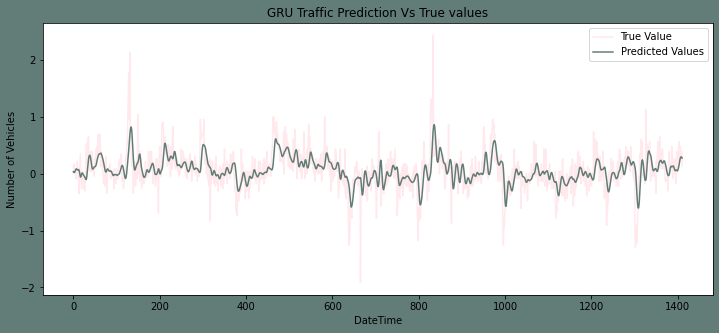

In [27]:
from sklearn.metrics import mean_squared_error
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

In [28]:
#Predictions For Second Junction
PredJ2 = LSTM_model(X_trainJ2,y_trainJ2,X_testJ2)

Epoch 1/50
88/88 [==============================] - ETA: 0s - loss: 0.3056

88/88 [==============================] - 8s 18ms/step - loss: 0.3056
Epoch 2/50
88/88 [==============================] - ETA: 0s - loss: 0.2740

88/88 [==============================] - 1s 17ms/step - loss: 0.2740
Epoch 3/50
87/88 [============================>.] - ETA: 0s - loss: 0.2523

88/88 [==============================] - 1s 17ms/step - loss: 0.2523
Epoch 4/50
87/88 [============================>.] - ETA: 0s - loss: 0.2437

88/88 [==============================] - 1s 17ms/step - loss: 0.2435
Epoch 5/50
87/88 [============================>.] - ETA: 0s - loss: 0.2351

88/88 [==============================] - 2s 17ms/step - loss: 0.2351
Epoch 6/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2296

88/88 [==============================] - 1s 16ms/step - loss: 0.2309
Epoch 7/50
88/88 [==============================] - ETA: 0s - loss: 0.2291

88/88 [==============================] - 1s 17ms/step - loss: 0.2291
Epoch 8/50
88/88 [==============================] - ETA: 0s - loss: 0.2243

88/88 [==============================] - 1s 17ms/step - loss: 0.2243
Epoch 9/50
87/88 [============================>.] - ETA: 0s - loss: 0.2221

88/88 [==============================] - 1s 16ms/step - loss: 0.2220
Epoch 10/50
86/88 [============================>.] - ETA: 0s - loss: 0.2209

88/88 [==============================] - 1s 16ms/step - loss: 0.2207
Epoch 11/50
86/88 [============================>.] - ETA: 0s - loss: 0.2181

88/88 [==============================] - 1s 16ms/step - loss: 0.2187
Epoch 12/50
88/88 [==============================] - ETA: 0s - loss: 0.2176

88/88 [==============================] - 1s 16ms/step - loss: 0.2176
Epoch 13/50
86/88 [============================>.] - ETA: 0s - loss: 0.2152

88/88 [==============================] - 1s 16ms/step - loss: 0.2148
Epoch 14/50
86/88 [============================>.] - ETA: 0s - loss: 0.2136

88/88 [==============================] - 1s 17ms/step - loss: 0.2134
Epoch 15/50
86/88 [============================>.] - ETA: 0s - loss: 0.2105

88/88 [==============================] - 1s 17ms/step - loss: 0.2105
Epoch 16/50
88/88 [==============================] - ETA: 0s - loss: 0.2096

88/88 [==============================] - 1s 16ms/step - loss: 0.2096
Epoch 17/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2065

88/88 [==============================] - 1s 16ms/step - loss: 0.2058
Epoch 18/50
88/88 [==============================] - ETA: 0s - loss: 0.2062

88/88 [==============================] - 2s 17ms/step - loss: 0.2062
Epoch 19/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2042

88/88 [==============================] - 1s 16ms/step - loss: 0.2035
Epoch 20/50
86/88 [============================>.] - ETA: 0s - loss: 0.2028

88/88 [==============================] - 1s 16ms/step - loss: 0.2027
Epoch 21/50
88/88 [==============================] - ETA: 0s - loss: 0.2021

88/88 [==============================] - 1s 16ms/step - loss: 0.2021
Epoch 22/50
86/88 [============================>.] - ETA: 0s - loss: 0.2007

88/88 [==============================] - 1s 17ms/step - loss: 0.2011
Epoch 23/50
88/88 [==============================] - ETA: 0s - loss: 0.1983

88/88 [==============================] - 1s 17ms/step - loss: 0.1983
Epoch 24/50
86/88 [============================>.] - ETA: 0s - loss: 0.1977

88/88 [==============================] - 1s 17ms/step - loss: 0.1971
Epoch 25/50
87/88 [============================>.] - ETA: 0s - loss: 0.1957

88/88 [==============================] - 1s 16ms/step - loss: 0.1956
Epoch 26/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1969

88/88 [==============================] - 1s 16ms/step - loss: 0.1966
Epoch 27/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1952

88/88 [==============================] - 1s 16ms/step - loss: 0.1949
Epoch 28/50
86/88 [============================>.] - ETA: 0s - loss: 0.1953

88/88 [==============================] - 1s 17ms/step - loss: 0.1953
Epoch 29/50
88/88 [==============================] - ETA: 0s - loss: 0.1941

88/88 [==============================] - 1s 17ms/step - loss: 0.1941
Epoch 30/50
86/88 [============================>.] - ETA: 0s - loss: 0.1926

88/88 [==============================] - 1s 16ms/step - loss: 0.1928
Epoch 31/50
87/88 [============================>.] - ETA: 0s - loss: 0.1935

88/88 [==============================] - 1s 16ms/step - loss: 0.1935
Epoch 32/50
88/88 [==============================] - ETA: 0s - loss: 0.1918

88/88 [==============================] - 1s 17ms/step - loss: 0.1918
Epoch 33/50
88/88 [==============================] - ETA: 0s - loss: 0.1917

88/88 [==============================] - 1s 16ms/step - loss: 0.1917
Epoch 34/50
88/88 [==============================] - ETA: 0s - loss: 0.1917

88/88 [==============================] - 1s 17ms/step - loss: 0.1917
Epoch 35/50
86/88 [============================>.] - ETA: 0s - loss: 0.1922

88/88 [==============================] - 2s 17ms/step - loss: 0.1921
Epoch 36/50
87/88 [============================>.] - ETA: 0s - loss: 0.1900

88/88 [==============================] - 1s 17ms/step - loss: 0.1900
Epoch 37/50
88/88 [==============================] - ETA: 0s - loss: 0.1895

88/88 [==============================] - 1s 17ms/step - loss: 0.1895
Epoch 38/50
86/88 [============================>.] - ETA: 0s - loss: 0.1899

88/88 [==============================] - 1s 16ms/step - loss: 0.1894
Epoch 39/50
85/88 [===========================>..] - ETA: 0s - loss: 0.1884

88/88 [==============================] - 1s 16ms/step - loss: 0.1888
Epoch 40/50
87/88 [============================>.] - ETA: 0s - loss: 0.1895

88/88 [==============================] - 1s 16ms/step - loss: 0.1895
Epoch 41/50
87/88 [============================>.] - ETA: 0s - loss: 0.1894

88/88 [==============================] - 1s 17ms/step - loss: 0.1895
Epoch 42/50
86/88 [============================>.] - ETA: 0s - loss: 0.1892

88/88 [==============================] - 1s 17ms/step - loss: 0.1890
Epoch 43/50
87/88 [============================>.] - ETA: 0s - loss: 0.1889

88/88 [==============================] - 1s 17ms/step - loss: 0.1889
Epoch 44/50
86/88 [============================>.] - ETA: 0s - loss: 0.1880

88/88 [==============================] - 2s 17ms/step - loss: 0.1882
Epoch 45/50
88/88 [==============================] - ETA: 0s - loss: 0.1886

88/88 [==============================] - 1s 17ms/step - loss: 0.1886
Epoch 46/50
86/88 [============================>.] - ETA: 0s - loss: 0.1875

88/88 [==============================] - 2s 17ms/step - loss: 0.1877
Epoch 47/50
86/88 [============================>.] - ETA: 0s - loss: 0.1874

88/88 [==============================] - 1s 16ms/step - loss: 0.1870
Epoch 48/50
88/88 [==============================] - ETA: 0s - loss: 0.1868

88/88 [==============================] - 1s 17ms/step - loss: 0.1868
Epoch 49/50
88/88 [==============================] - ETA: 0s - loss: 0.1871

88/88 [==============================] - 1s 17ms/step - loss: 0.1871
Epoch 50/50
87/88 [============================>.] - ETA: 0s - loss: 0.1863

45/45 [==============================] - 2s 6ms/step


The root mean squared error is 0.5825441593897205.


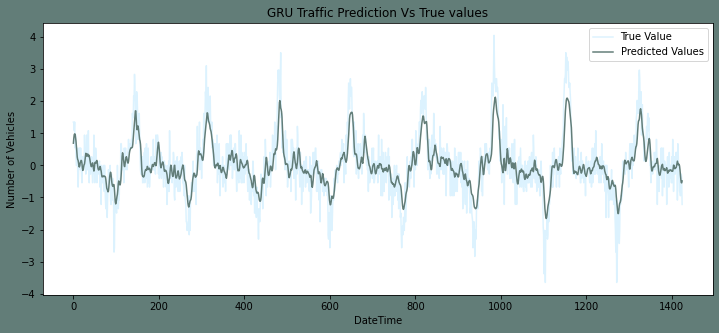

In [29]:
#Results for J2
RMSE_J2=RMSE_Value(y_testJ2,PredJ2)
PredictionsPlot(y_testJ2,PredJ2,1)

In [30]:
#Predictions For Third Junction
PredJ3 = LSTM_model(X_trainJ3,y_trainJ3,X_testJ3) 

Epoch 1/50
86/88 [============================>.] - ETA: 0s - loss: 0.3068

88/88 [==============================] - 8s 18ms/step - loss: 0.3049
Epoch 2/50
86/88 [============================>.] - ETA: 0s - loss: 0.3062

88/88 [==============================] - 2s 17ms/step - loss: 0.3050
Epoch 3/50
88/88 [==============================] - ETA: 0s - loss: 0.3041

88/88 [==============================] - 1s 16ms/step - loss: 0.3041
Epoch 4/50
85/88 [===========================>..] - ETA: 0s - loss: 0.3080

88/88 [==============================] - 1s 17ms/step - loss: 0.3046
Epoch 5/50
85/88 [===========================>..] - ETA: 0s - loss: 0.3048

88/88 [==============================] - 1s 17ms/step - loss: 0.3043
Epoch 6/50
85/88 [===========================>..] - ETA: 0s - loss: 0.3017

88/88 [==============================] - 1s 16ms/step - loss: 0.3035
Epoch 7/50
87/88 [============================>.] - ETA: 0s - loss: 0.3043

88/88 [==============================] - 1s 17ms/step - loss: 0.3038
Epoch 8/50
87/88 [============================>.] - ETA: 0s - loss: 0.3035

88/88 [==============================] - 1s 17ms/step - loss: 0.3029
Epoch 9/50
85/88 [===========================>..] - ETA: 0s - loss: 0.3036

88/88 [==============================] - 1s 17ms/step - loss: 0.3024
Epoch 10/50
87/88 [============================>.] - ETA: 0s - loss: 0.2974

88/88 [==============================] - 1s 17ms/step - loss: 0.3015
Epoch 11/50
85/88 [===========================>..] - ETA: 0s - loss: 0.3023

88/88 [==============================] - 1s 17ms/step - loss: 0.3006
Epoch 12/50
86/88 [============================>.] - ETA: 0s - loss: 0.2976

88/88 [==============================] - 1s 17ms/step - loss: 0.2983
Epoch 13/50
86/88 [============================>.] - ETA: 0s - loss: 0.2960

88/88 [==============================] - 1s 16ms/step - loss: 0.2947
Epoch 14/50
87/88 [============================>.] - ETA: 0s - loss: 0.2941

88/88 [==============================] - 1s 16ms/step - loss: 0.2935
Epoch 15/50
87/88 [============================>.] - ETA: 0s - loss: 0.2927

88/88 [==============================] - 1s 16ms/step - loss: 0.2924
Epoch 16/50
88/88 [==============================] - ETA: 0s - loss: 0.2911

88/88 [==============================] - 1s 17ms/step - loss: 0.2911
Epoch 17/50
86/88 [============================>.] - ETA: 0s - loss: 0.2895

88/88 [==============================] - 1s 16ms/step - loss: 0.2902
Epoch 18/50
88/88 [==============================] - ETA: 0s - loss: 0.2910

88/88 [==============================] - 2s 17ms/step - loss: 0.2910
Epoch 19/50
86/88 [============================>.] - ETA: 0s - loss: 0.2894

88/88 [==============================] - 1s 17ms/step - loss: 0.2896
Epoch 20/50
86/88 [============================>.] - ETA: 0s - loss: 0.2926

88/88 [==============================] - 1s 17ms/step - loss: 0.2937
Epoch 21/50
87/88 [============================>.] - ETA: 0s - loss: 0.2878

88/88 [==============================] - 1s 17ms/step - loss: 0.2905
Epoch 22/50
88/88 [==============================] - ETA: 0s - loss: 0.2900

88/88 [==============================] - 1s 16ms/step - loss: 0.2900
Epoch 23/50
86/88 [============================>.] - ETA: 0s - loss: 0.2882

88/88 [==============================] - 1s 17ms/step - loss: 0.2894
Epoch 24/50
88/88 [==============================] - ETA: 0s - loss: 0.2888

88/88 [==============================] - 1s 16ms/step - loss: 0.2888
Epoch 25/50
87/88 [============================>.] - ETA: 0s - loss: 0.2897

88/88 [==============================] - 1s 17ms/step - loss: 0.2890
Epoch 26/50
87/88 [============================>.] - ETA: 0s - loss: 0.2913

88/88 [==============================] - 1s 17ms/step - loss: 0.2908
Epoch 27/50
88/88 [==============================] - ETA: 0s - loss: 0.2888

88/88 [==============================] - 1s 17ms/step - loss: 0.2888
Epoch 28/50
86/88 [============================>.] - ETA: 0s - loss: 0.2902

88/88 [==============================] - 1s 16ms/step - loss: 0.2895
Epoch 29/50
88/88 [==============================] - ETA: 0s - loss: 0.2898

88/88 [==============================] - 1s 17ms/step - loss: 0.2898
Epoch 30/50
86/88 [============================>.] - ETA: 0s - loss: 0.2869

88/88 [==============================] - 1s 17ms/step - loss: 0.2901
Epoch 31/50
87/88 [============================>.] - ETA: 0s - loss: 0.2887

88/88 [==============================] - 1s 17ms/step - loss: 0.2886
Epoch 32/50
87/88 [============================>.] - ETA: 0s - loss: 0.2857

88/88 [==============================] - 1s 17ms/step - loss: 0.2881
Epoch 33/50
87/88 [============================>.] - ETA: 0s - loss: 0.2895

88/88 [==============================] - 1s 17ms/step - loss: 0.2889
Epoch 34/50
88/88 [==============================] - ETA: 0s - loss: 0.2886

88/88 [==============================] - 1s 17ms/step - loss: 0.2886
Epoch 35/50
88/88 [==============================] - ETA: 0s - loss: 0.2889

88/88 [==============================] - 1s 17ms/step - loss: 0.2889
Epoch 36/50
86/88 [============================>.] - ETA: 0s - loss: 0.2881

88/88 [==============================] - 1s 16ms/step - loss: 0.2884
Epoch 37/50
86/88 [============================>.] - ETA: 0s - loss: 0.2901

88/88 [==============================] - 1s 16ms/step - loss: 0.2893
Epoch 38/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2919

88/88 [==============================] - 1s 16ms/step - loss: 0.2884
Epoch 39/50
86/88 [============================>.] - ETA: 0s - loss: 0.2879

88/88 [==============================] - 2s 17ms/step - loss: 0.2876
Epoch 40/50
88/88 [==============================] - ETA: 0s - loss: 0.2872

88/88 [==============================] - 1s 17ms/step - loss: 0.2872
Epoch 41/50
86/88 [============================>.] - ETA: 0s - loss: 0.2866

88/88 [==============================] - 1s 17ms/step - loss: 0.2862
Epoch 42/50
87/88 [============================>.] - ETA: 0s - loss: 0.2870

88/88 [==============================] - 1s 17ms/step - loss: 0.2862
Epoch 43/50
86/88 [============================>.] - ETA: 0s - loss: 0.2900

88/88 [==============================] - 1s 17ms/step - loss: 0.2878
Epoch 44/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2858

88/88 [==============================] - 1s 17ms/step - loss: 0.2871
Epoch 45/50
85/88 [===========================>..] - ETA: 0s - loss: 0.2850

88/88 [==============================] - 1s 17ms/step - loss: 0.2855
Epoch 46/50
87/88 [============================>.] - ETA: 0s - loss: 0.2877

88/88 [==============================] - 2s 23ms/step - loss: 0.2871
Epoch 47/50
88/88 [==============================] - ETA: 0s - loss: 0.2866

88/88 [==============================] - 2s 19ms/step - loss: 0.2866
Epoch 48/50
86/88 [============================>.] - ETA: 0s - loss: 0.2840

88/88 [==============================] - 2s 22ms/step - loss: 0.2858
Epoch 49/50
88/88 [==============================] - ETA: 0s - loss: 0.2857

88/88 [==============================] - 2s 24ms/step - loss: 0.2857
Epoch 50/50
86/88 [============================>.] - ETA: 0s - loss: 0.2871

45/45 [==============================] - 2s 6ms/step


The root mean squared error is 0.6224001409198581.


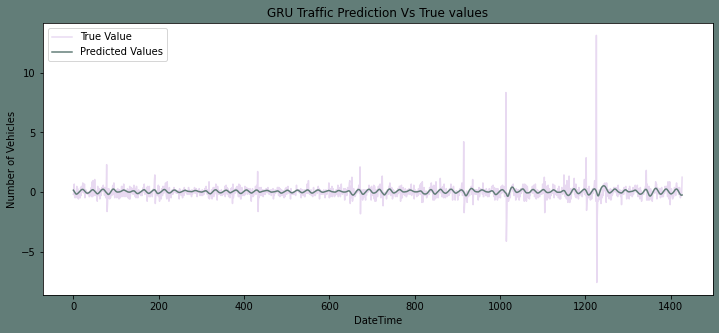

In [31]:
#Results for J3
RMSE_J3=RMSE_Value(y_testJ3,PredJ3)
PredictionsPlot(y_testJ3,PredJ3,2)

In [32]:
#Predictions For Forth Junction
PredJ4 = LSTM_model(X_trainJ4,y_trainJ4,X_testJ4)

Epoch 1/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6909

26/26 [==============================] - 7s 20ms/step - loss: 0.6891
Epoch 2/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6792

26/26 [==============================] - 0s 17ms/step - loss: 0.6902
Epoch 3/50
26/26 [==============================] - ETA: 0s - loss: 0.6897

26/26 [==============================] - 0s 18ms/step - loss: 0.6897
Epoch 4/50
24/26 [==========================>...] - ETA: 0s - loss: 0.7004

26/26 [==============================] - 0s 17ms/step - loss: 0.6902
Epoch 5/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6780

26/26 [==============================] - 0s 16ms/step - loss: 0.6889
Epoch 6/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6898

26/26 [==============================] - 0s 17ms/step - loss: 0.6913
Epoch 7/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6906

26/26 [==============================] - 0s 17ms/step - loss: 0.6910
Epoch 8/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6935

26/26 [==============================] - 0s 17ms/step - loss: 0.6918
Epoch 9/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6941

26/26 [==============================] - 0s 18ms/step - loss: 0.6883
Epoch 10/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6977

26/26 [==============================] - 0s 16ms/step - loss: 0.6899
Epoch 11/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6896

26/26 [==============================] - 0s 16ms/step - loss: 0.6883
Epoch 12/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6869

26/26 [==============================] - 0s 16ms/step - loss: 0.6897
Epoch 13/50
26/26 [==============================] - ETA: 0s - loss: 0.6889

26/26 [==============================] - 0s 17ms/step - loss: 0.6889
Epoch 14/50
26/26 [==============================] - ETA: 0s - loss: 0.6883

26/26 [==============================] - 0s 17ms/step - loss: 0.6883
Epoch 15/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6928

26/26 [==============================] - 0s 16ms/step - loss: 0.6881
Epoch 16/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6829

26/26 [==============================] - 0s 16ms/step - loss: 0.6891
Epoch 17/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6870

26/26 [==============================] - 0s 17ms/step - loss: 0.6900
Epoch 18/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6732

26/26 [==============================] - 0s 16ms/step - loss: 0.6894
Epoch 19/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6843

26/26 [==============================] - 0s 18ms/step - loss: 0.6880
Epoch 20/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6860

26/26 [==============================] - 0s 16ms/step - loss: 0.6877
Epoch 21/50
26/26 [==============================] - ETA: 0s - loss: 0.6858

26/26 [==============================] - 0s 17ms/step - loss: 0.6858
Epoch 22/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6949

26/26 [==============================] - 0s 17ms/step - loss: 0.6896
Epoch 23/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6993

26/26 [==============================] - 0s 17ms/step - loss: 0.6878
Epoch 24/50
26/26 [==============================] - ETA: 0s - loss: 0.6852

26/26 [==============================] - 0s 17ms/step - loss: 0.6852
Epoch 25/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6885

26/26 [==============================] - 0s 17ms/step - loss: 0.6872
Epoch 26/50
26/26 [==============================] - ETA: 0s - loss: 0.6839

26/26 [==============================] - 0s 17ms/step - loss: 0.6839
Epoch 27/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6854

26/26 [==============================] - 0s 16ms/step - loss: 0.6839
Epoch 28/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6813

26/26 [==============================] - 0s 18ms/step - loss: 0.6824
Epoch 29/50
26/26 [==============================] - ETA: 0s - loss: 0.6827

26/26 [==============================] - 0s 17ms/step - loss: 0.6827
Epoch 30/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6806

26/26 [==============================] - 0s 17ms/step - loss: 0.6786
Epoch 31/50
26/26 [==============================] - ETA: 0s - loss: 0.6794

26/26 [==============================] - 0s 17ms/step - loss: 0.6794
Epoch 32/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6886

26/26 [==============================] - 0s 17ms/step - loss: 0.6782
Epoch 33/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6748

26/26 [==============================] - 0s 17ms/step - loss: 0.6769
Epoch 34/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6776

26/26 [==============================] - 0s 16ms/step - loss: 0.6780
Epoch 35/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6819

26/26 [==============================] - 0s 17ms/step - loss: 0.6764
Epoch 36/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6766

26/26 [==============================] - 0s 17ms/step - loss: 0.6766
Epoch 37/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6794

26/26 [==============================] - 0s 17ms/step - loss: 0.6753
Epoch 38/50
26/26 [==============================] - ETA: 0s - loss: 0.6777

26/26 [==============================] - 0s 16ms/step - loss: 0.6777
Epoch 39/50
26/26 [==============================] - ETA: 0s - loss: 0.6781

26/26 [==============================] - 0s 17ms/step - loss: 0.6781
Epoch 40/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6777

26/26 [==============================] - 0s 17ms/step - loss: 0.6795
Epoch 41/50
26/26 [==============================] - ETA: 0s - loss: 0.6773

26/26 [==============================] - 0s 16ms/step - loss: 0.6773
Epoch 42/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6580

26/26 [==============================] - 0s 16ms/step - loss: 0.6741
Epoch 43/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6695

26/26 [==============================] - 0s 16ms/step - loss: 0.6738
Epoch 44/50
23/26 [=========================>....] - ETA: 0s - loss: 0.6705

26/26 [==============================] - 0s 17ms/step - loss: 0.6762
Epoch 45/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6733

26/26 [==============================] - 0s 19ms/step - loss: 0.6775
Epoch 46/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6709

26/26 [==============================] - 0s 17ms/step - loss: 0.6734
Epoch 47/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6774

26/26 [==============================] - 0s 17ms/step - loss: 0.6717
Epoch 48/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6852

26/26 [==============================] - 0s 17ms/step - loss: 0.6790
Epoch 49/50
24/26 [==========================>...] - ETA: 0s - loss: 0.6789

26/26 [==============================] - 0s 17ms/step - loss: 0.6734
Epoch 50/50
25/26 [===========================>..] - ETA: 0s - loss: 0.6743

13/13 [==============================] - 2s 7ms/step


The root mean squared error is 1.0974536501959722.


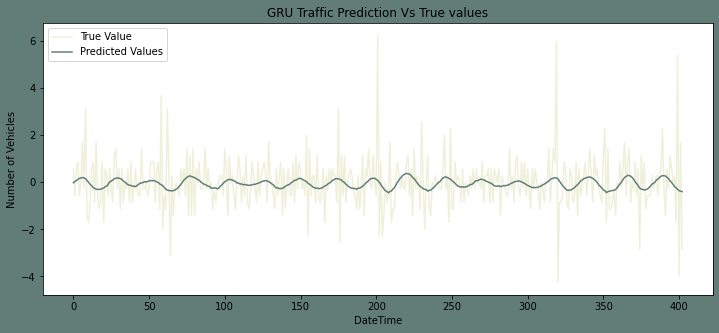

In [33]:
#Results for J4
RMSE_J4=RMSE_Value(y_testJ4,PredJ4)
PredictionsPlot(y_testJ4,PredJ4,3)